<a href="https://colab.research.google.com/github/aasthad27/Twitter_Sentimental_Analysis/blob/main/TwitterSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import re

In [ ]:
# The 'warnings' library is used to suppress warning messages. 'pandas' and 'numpy' are used for
# data manipulation and manipulation.
# 'matplotlib' and 'seaborn' are used for data visualization. 
#'train_test_split' and 'GridSearchCV' from 'sklearn.model_selection' are used for splitting data
# into training and testing sets and hyperparameter tuning, respectively. 
#'confusion_matrix' and 'f1_score' from 'sklearn.metrics' are used for evaluating model performance.
# 'MultinomialNB' and 'RandomForestClassifier' from 'sklearn.naive_bayes' and 'sklearn.ensemble',
# respectively, are used for building the models. 
#'accuracy_score', 'confusion_matrix' and 'classification_report' from 'sklearn.metrics' are used for 
#evaluating the model performance. 're' is used for regular expression operations.

In [ ]:
#ALTERNATIVE LIBRARIES CAN BE USED 
#NLTK: The Natural Language Toolkit is a library for working with human language data in Python. 
#It contains tools for tokenization, stemming, tagging, and more.
#spaCy: spaCy is a library for advanced natural language processing in Python. 
#It is designed specifically for production use and is fast and efficient.
#Gensim:  It is designed to handle large corpora of text and is highly optimized for performance.
#Keras:  It is useful for deep learning tasks such as text classification.
#TextBlob: TextBlob is a Python (2 and 3) library for processing textual data. 

In [ ]:
df = pd.read_csv('/content/train_E6oV3lV.csv')
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
hate_tweet = df[df.label == 1]
hate_tweet.head()

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...


In [ ]:
normal_tweet = df[df.label == 0]
normal_tweet.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


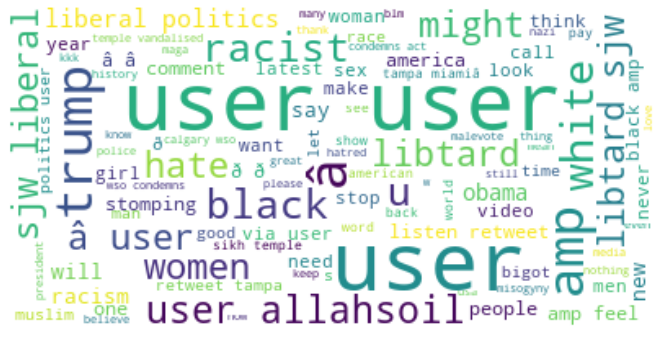

In [ ]:
# Hate Word clouds
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(review for review in hate_tweet.tweet)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig = plt.figure(figsize = (20, 6)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
#distributions
df_Stat=df[['label','tweet']].groupby('label').count().reset_index()
df_Stat.columns=['label','count']
df_Stat['percentage']=(df_Stat['count']/df_Stat['count'].sum())*100
df_Stat

,label,count,percentage
0,0,29720,92.98542
1,1,2242,7.01458


In [ ]:
def process_tweet(tweet):
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",tweet.lower()).split())

In [ ]:
df['processed_tweets'] = df['tweet'].apply(process_tweet)
df.head()

,id,label,tweet,processed_tweets
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i can t use cause they ...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ur
4,5,0,factsguide: society now #motivation,factsguide society now motivation


In [ ]:
#As this dataset is highly imbalance we have to balance this by over sampling
cnt_non_fraud = df[df['label'] == 0]['processed_tweets'].count()
df_class_fraud = df[df['label'] == 1]
df_class_nonfraud = df[df['label'] == 0]
df_class_fraud_oversample = df_class_fraud.sample(cnt_non_fraud, replace=True)
df_oversampled = pd.concat([df_class_nonfraud, df_class_fraud_oversample], axis=0)

print('Random over-sampling:')
print(df_oversampled['label'].value_counts())

Random over-sampling:
0    29720
1    29720
Name: label, dtype: int64


In [ ]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split
X = df_oversampled['processed_tweets']
y = df_oversampled['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = None)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
count_vect = CountVectorizer(stop_words='english')
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

In [ ]:
x_train_counts = count_vect.fit_transform(X_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)

In [ ]:
print(x_train_counts.shape)
print(x_train_tfidf.shape)

(47552, 33946)
(47552, 33946)


In [ ]:
x_test_counts = count_vect.transform(X_test)
x_test_tfidf = transformer.transform(x_test_counts)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=500)
model.fit(x_train_tfidf,y_train)

RandomForestClassifier(n_estimators=500)

In [ ]:
RandomForestClassifier(n_estimators=500)

RandomForestClassifier(n_estimators=500)

In [ ]:
predictions = model.predict(x_test_tfidf)

In [ ]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))

[[5800  194]
 [   0 5894]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      5994
           1       0.97      1.00      0.98      5894

    accuracy                           0.98     11888
   macro avg       0.98      0.98      0.98     11888
weighted avg       0.98      0.98      0.98     11888



In [ ]:
from sklearn.metrics import confusion_matrix

# create the confusion matrix
confusion_mat = confusion_matrix(y_test, predictions)

# print the confusion matrix
print(confusion_mat)

[[5800  194]
 [   0 5894]]


Text(33.0, 0.5, 'True')

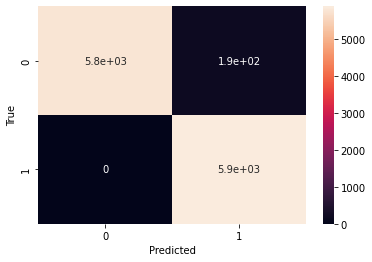

In [ ]:
import seaborn as sns

sns.heatmap(confusion_mat, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')


In [ ]:
#Building XGBoost Model
from xgboost import XGBClassifier
model_bow = XGBClassifier(random_state=22,learning_rate=0.9)
model_bow.fit(x_train_tfidf,y_train)

XGBClassifier(learning_rate=0.9, random_state=22)

In [ ]:
predict_xgb = model_bow.predict(x_test_tfidf)


In [ ]:
print(confusion_matrix(y_test,predict_xgb))
print(classification_report(y_test,predict_xgb))

[[5572  422]
 [ 672 5222]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      5994
           1       0.93      0.89      0.91      5894

    accuracy                           0.91     11888
   macro avg       0.91      0.91      0.91     11888
weighted avg       0.91      0.91      0.91     11888



In [ ]:
#SVM Model
from sklearn import svm
lin_clf = svm.LinearSVC()
lin_clf.fit(x_train_tfidf,y_train)

LinearSVC()

In [ ]:
predict_svm = lin_clf.predict(x_test_tfidf)

In [ ]:
from sklearn.metrics import confusion_matrix,f1_score
print(confusion_matrix(y_test,predict_svm))
print(classification_report(y_test, predict_svm))

[[5833  161]
 [  14 5880]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      5994
           1       0.97      1.00      0.99      5894

    accuracy                           0.99     11888
   macro avg       0.99      0.99      0.99     11888
weighted avg       0.99      0.99      0.99     11888



In [ ]:
#Logistic Regression Model
from sklearn.linear_model import LogisticRegression

In [ ]:
logreg = LogisticRegression(random_state=42)

In [ ]:
#Building Logistic Regression  Model
logreg.fit(x_train_tfidf,y_train)

LogisticRegression(random_state=42)

In [ ]:
predict_log = logreg.predict(x_test_tfidf)

In [ ]:
print(confusion_matrix(y_test,predict_log))
print(classification_report(y_test, predict_log))

[[5737  257]
 [  41 5853]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      5994
           1       0.96      0.99      0.98      5894

    accuracy                           0.97     11888
   macro avg       0.98      0.98      0.97     11888
weighted avg       0.98      0.97      0.97     11888



In [ ]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
NB.fit(x_train_tfidf, y_train)

MultinomialNB()

In [ ]:
predict_nb = NB.predict(x_test_tfidf)

In [ ]:
print(confusion_matrix(y_test,predict_nb))
print(classification_report(y_test, predict_nb))

[[5441  553]
 [  73 5821]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      5994
           1       0.91      0.99      0.95      5894

    accuracy                           0.95     11888
   macro avg       0.95      0.95      0.95     11888
weighted avg       0.95      0.95      0.95     11888



In [ ]:
#Test Data Set
df_test = pd.read_csv('/content/test_tweets_anuFYb8.csv')
df_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [ ]:
df_test.shape

(17197, 2)

In [ ]:
df_test['processed_tweets'] = df_test['tweet'].apply(process_tweet)
df_test.head()

,id,tweet,processed_tweets
0,31963,#studiolife #aislife #requires #passion #dedic...,studiolife aislife requires passion dedication...
1,31964,@user #white #supremacists want everyone to s...,white supremacists want everyone to see the ne...
2,31965,safe ways to heal your #acne!! #altwaystohe...,safe ways to heal your acne altwaystoheal heal...
3,31966,is the hp and the cursed child book up for res...,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",3rd bihday to my amazing hilarious nephew eli ...


In [ ]:
X = df_test['processed_tweets']
x_test_counts = count_vect.transform(X)
x_test_tfidf = transformer.transform(x_test_counts)

In [ ]:
df_test['predict_nb'] = NB.predict(x_test_tfidf)
df_test[df_test['predict_nb']==1]

,id,tweet,processed_tweets,predict_nb
19,31982,thought factory: bbc neutrality on right wing ...,thought factory bbc neutrality on right wing f...,1
26,31989,chick gets fucked hottest naked lady,chick gets fucked hottest naked lady,1
33,31996,suppo the #taiji fisherman! no bullying! no ra...,suppo the taiji fisherman no bullying no racis...,1
34,31997,i say we because i'm speaking collectively. i'...,i say we because i m speaking collectively i v...,1
35,31998,wish we could talk,wish we could talk,1
...,...,...,...,...
17163,49126,@user @user i'd be ashamed of my state if i to...,i d be ashamed of my state if i took any respo...,1
17176,49139,@user @user are the most racist pay ever!!!!!,are the most racist pay ever,1
17188,49151,"black professor demonizes, proposes nazi style...",black professor demonizes proposes nazi style ...,1
17192,49155,thought factory: left-right polarisation! #tru...,thought factory left right polarisation trump ...,1


In [ ]:
df_test['predict_svm'] = NB.predict(x_test_tfidf)
df_test['predict_rf'] = model.predict(x_test_tfidf)
df_test.head()

,id,tweet,processed_tweets,predict_nb,predict_svm,predict_rf
0,31963,#studiolife #aislife #requires #passion #dedic...,studiolife aislife requires passion dedication...,0,0,1
1,31964,@user #white #supremacists want everyone to s...,white supremacists want everyone to see the ne...,0,0,1
2,31965,safe ways to heal your #acne!! #altwaystohe...,safe ways to heal your acne altwaystoheal heal...,0,0,0
3,31966,is the hp and the cursed child book up for res...,is the hp and the cursed child book up for res...,0,0,0
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",3rd bihday to my amazing hilarious nephew eli ...,0,0,0


In [ ]:
file_name = 'test_predictions_Twitter Hate Analysis.csv'
df_test.to_csv(file_name,index=False)

In [ ]:
# **Results**

#Algorithms                                  F1-Score

#SVM                                            99%

#Random Forest                                  98%

#XG Boost                                       91%

#Navie Bayes                                    95%

#Logistic Regression                            98%

In [ ]:
import joblib
joblib.dump(model,'model.pkl')

['model.pkl']

In [ ]:
model=joblib.load('/content/model.pkl')

In [ ]:
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Pre-processing function
def process_tweet(tweet):
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",tweet.lower()).split())

# CountVectorizer and Tf-idf Transformer
count_vect = CountVectorizer(stop_words='english')
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

# Fit count_vect and transformer on the train data
count_vect.fit(X_train)
x_train_counts = count_vect.transform(X_train)
transformer.fit(x_train_counts)

# Load the best-performing model
# Replace with the appropriate model
model = RandomForestClassifier(n_estimators=500)

# Take user input
user_input = input("Enter your tweet: ")

# Pre-process the user input
processed_input = process_tweet(user_input)

# Convert the user input to numerical form
user_input_counts = count_vect.transform([processed_input])
user_input_tfidf = transformer.transform(user_input_counts)
# Fit the model on the train data
model.fit(x_train_tfidf,y_train)

# Predict whether the user input is hate speech or not
prediction = model.predict(user_input_tfidf)

# Print the result
if prediction[0] == 1:
    print("This tweet is hate speech.")
else:
    print("This tweet is not hate speech.")


This tweet is not hate speech.


In [ ]:
# input/output
#"I hate this #racism"
#"I love my country"